# Statically tunable switching of focusing target


## Imports

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=16"  # Use 8 CPU cores for JAX pmap 

from difflexmm.utils import SolutionData, save_data, load_data, ControlParams, GeometricalParams, MechanicalParams, ContactParams
from difflexmm.geometry import QuadGeometry, compute_inertia, compute_xy_limits
from difflexmm.energy import kinetic_energy, build_contact_energy, ligament_strains
from difflexmm.kinematics import block_to_node_kinematics
from difflexmm.plotting import generate_animation, plot_geometry
from problems.quads_kinetic_energy_static_tuning import ForwardInput, ForwardProblem, OptimizationProblem
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from typing import Any, Optional, List
import pandas as pd

import jax.numpy as jnp
from jax import pmap
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


## Plotting functions


In [69]:
from difflexmm.energy import contact_energy, void_angles


def plot_objective_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None):

    fig, axes = plt.subplots(nrows=5, figsize=(
        10, 10), sharex=True, constrained_layout=True)
    axes[0].set(ylabel="Objective")
    axes[0].plot(optimization.objective_values, lw=3, color="#2980b9")
    axes[1].set(ylabel="Objective 1")
    axes[1].plot(jnp.array(optimization.objective_values_individual)[
                 :, 0], lw=3, color="#2980b9")
    axes[2].set(ylabel="Objective 2")
    axes[2].plot(jnp.array(optimization.objective_values_individual)[
                 :, 1], lw=3, color="#2980b9")
    axes[3].set(ylabel="Angle constraints violation")
    axes[3].plot(optimization.constraints_violation["angles"],
                 lw=3, color="#c0392b")
    axes[3].axhline(y=0, color="black")
    axes[4].set(ylabel="Edge length constraints violation")
    axes[4].plot(optimization.constraints_violation["edge_lengths"],
                 lw=3, color="#c0392b")
    axes[4].axhline(y=0, color="black")
    axes[-1].set(xlabel="Iteration")

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def plot_pareto_front(pareto_objectives_data: List, figsize=(4, 4), fontsize=14, ticksize=12, xlim=None, ylim=None, grid=True, colors=("#bdc3c7", "#bdc3c7")):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Create a radial color gradient
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "pareto",
        colors,
    )
    max_objective_value = max(
        [jnp.linalg.norm(objective_values_ray, axis=1).max()
         for objective_values_ray in pareto_objectives_data]
    )
    # Plot pareto front
    for objective_values_ray in pareto_objectives_data:
        axes.scatter(
            objective_values_ray[:, 0], objective_values_ray[:, 1],
            s=3,
            color=cmap(jnp.linalg.norm(
                objective_values_ray, axis=1)/max_objective_value),
        )
    axes.set_xlabel(r"Energy focused at T1 [mJ]", fontsize=fontsize)
    axes.set_ylabel(r"Energy focused at T2 [mJ]", fontsize=fontsize)
    axes.axis("equal")
    axes.tick_params(labelsize=ticksize)

    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if not grid:
        axes.grid(False)

    return fig, axes


def generate_response_animations(
        optimization: OptimizationProblem,
        optimization_filename: str,
        filename_prefix: str,
        full_simulation_time: bool = False,
        n_timepoints: int = 200,
        recompute: bool = False,
        **plot_kwargs):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    forward_input_array = jnp.array([
        optimization.forward_input.amplitude,
        optimization.forward_input.loading_rate,
        optimization.forward_input.compressive_strain,
        optimization.forward_input.compressive_strain_rate,
    ]).T

    # Drop alien stuff from plot_kwargs
    plot_kwargs.pop("filename_prefix", None)
    plot_kwargs.pop("iteration", None)

    if recompute or len(optimization.forward_problem.solution_data) == 0:
        for forward_input, target_size, target_shift in zip(forward_input_array, optimization.target_sizes, optimization.target_shifts):
            _, _, compressive_strain, _ = forward_input
            solution = optimization.forward_problem.solve(
                optimization.design_values[-1], *forward_input, full_simulation_time=full_simulation_time, n_timepoints=n_timepoints)
            xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
                *optimization.design_values[-1]) + 0.5*optimization.forward_problem.spacing * jnp.array([-1, 1])

            generate_animation(
                data=solution,
                out_filename=f"../out/{optimization.name}/{optimization_filename}/{filename_prefix}_target_size_{target_size}_target_shift_{target_shift}_compressive_strain_{compressive_strain}",
                deformed=True,
                xlim=xlim,
                ylim=ylim,
                **plot_kwargs
            )
    else:
        for forward_input, target_size, target_shift, solution in zip(forward_input_array, optimization.target_sizes, optimization.target_shifts, optimization.forward_problem.solution_data):
            _, _, compressive_strain, _ = forward_input
            xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
                *optimization.design_values[-1]) + 0.5*optimization.forward_problem.spacing * jnp.array([-1, 1])

            generate_animation(
                data=solution,
                out_filename=f"../out/{optimization.name}/{optimization_filename}/{filename_prefix}_target_size_{target_size}_target_shift_{target_shift}_compressive_strain_{compressive_strain}",
                deformed=True,
                xlim=xlim,
                ylim=ylim,
                **plot_kwargs
            )


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, design_label: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True, field_values=None, cmap: Any ="inferno", color=None, cmap_label=None, scaling=1., deformed=False, block_displacements=None):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problem.spacing * jnp.array([[-1., 1.], [-0.5, 0.5]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problem.geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problem.geometry.bond_connectivity(),
        deformed=deformed,
        block_displacements=block_displacements,
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    if field_values is not None and color is None:
        axes.collections[0].set_array(field_values)
        axes.collections[0].set_cmap(cmap)
        axes.collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling, vmin=jnp.min(field_values), vmax=jnp.max(field_values)
            )
        )
        cb = fig.colorbar(axes.collections[0], ax=axes, pad=0.01, aspect=30)
        cb.ax.tick_params(
            labelsize=0.8*fontsize if fontsize is not None else None)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    if optimization_filename is not None:
        _design_label = f"design_{iteration_label:03d}_{design_label}" if design_label is not None else f"design_{iteration_label:03d}"
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/{_design_label}.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)

    return fig, axes


def kinetic_energy_per_block(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def average_kinetic_energy_per_block(solution_data, blocks_inertia):
    return jnp.sum(
        kinetic_energy_per_block(
            solution_data.fields[:, 1],
            blocks_inertia,
        )/solution_data.timepoints.shape[0],
        axis=0,
    )


def compute_ligament_strains(block_displacement, centroid_node_vectors, bond_connectivity, reference_bond_vectors):
    node_displacements = block_to_node_kinematics(
        block_displacement,
        centroid_node_vectors
    ).reshape(-1, 3)
    return ligament_strains(node_displacements[bond_connectivity[:, 0]],
                            node_displacements[bond_connectivity[:, 1]],
                            reference_vector=reference_bond_vectors)


def compute_contact_energies(block_displacement: jnp.ndarray, control_params: ControlParams, bond_connectivity):
    block_centroids = control_params.geometrical_params.block_centroids
    centroid_node_vectors = control_params.geometrical_params.centroid_node_vectors
    contact_params = control_params.mechanical_params.contact_params

    node_displacements = jnp.array(
        block_to_node_kinematics(
            block_displacement,
            centroid_node_vectors
        )
    )[:, :, :2]
    current_block_nodes = block_centroids[:, None] + \
        centroid_node_vectors + node_displacements
    energies = contact_energy(current_void_angles=void_angles(
        current_block_nodes, bond_connectivity), **contact_params._asdict())
    return jnp.sum(energies.reshape(2, -1), axis=0)


def plot_strains_and_kinetic_energy_evolution_T(optimization: OptimizationProblem, solution_data: SolutionData, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap_strains="inferno", cmap_kinetic="inferno", show_ticks=True, time_label_pos="right"):
    # Same as plot_strains_and_kinetic_energy_evolution but transposed
    problem = optimization.forward_problem
    column_labels = ["Shear", "Bending", "Kinetic"]
    time_labels = [
        f"$t$ = {(solution_data.timepoints-solution_data.timepoints[0])[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=3, ncols=len(timepoints), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[0], time_labels):
        ax.set_title(label, fontsize=fontsize)
    # Remove all ticks
    if not show_ticks:
        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        # Add supxlabel at the bottom
        fig.supxlabel(r"$x$ [mm]", fontsize=fontsize,
                      x=0.55, y=0.1, ha="center", va="center")
        # Add supylabel on the right
        fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                      y=0.55, ha="left", va="center")
        for ax in axes[-1]:
            # ax.yaxis.set_label_position("right")
            # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, 0]:
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, -1]:
            # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)

    # Add time labels on the right
    if time_label_pos == "right":
        for ax, label in zip(axes[:, -1], column_labels):
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(label, fontsize=fontsize, labelpad=4)
    elif time_label_pos == "left":
        for ax, label in zip(axes[:, 0], column_labels):
            ax.set_ylabel(label, fontsize=fontsize, labelpad=4)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    velocities = [solution_data.fields[timepoint, 1]
                  for timepoint in timepoints]
    # Compute strain energy
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        for displacement in displacements]
    strain_fields = jnp.array(strain_fields)
    strain_energies = jnp.array([
        [problem.k_shear * (strain_fields_i[1]*problem.bond_length)
            ** 2/2, problem.k_rot*strain_fields_i[2]**2/2]
        for strain_fields_i in strain_fields
    ])
    # Strain energy values limits
    strain_energy_min, strain_energy_max = jnp.min(
        strain_energies), jnp.max(strain_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        kinetic_energy_per_block(
            velocity,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for velocity in velocities
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # Plot strain energies in the first two
    for (ax0, ax1), (shear_energy, bending_energy) in zip(axes[:2].T, strain_energies):
        ax0.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], shear_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=matplotlib.colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
        ax1.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], bending_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=matplotlib.colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
    # Plot kinetic energies in the right column
    for ax, kinetic_energy in zip(axes[-1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap_kinetic, shading='gouraud',
            norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                             vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    # Remove all ticks and axes labels
    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])

    strain_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
                                        cmap=cmap_strains)
    kinetic_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max,),
                                         cmap=cmap_kinetic)
    cb_strains = fig.colorbar(strain_mappable, ax=axes[:2, -1], pad=0.25 if show_ticks else 0.11, aspect=25,
                              orientation="vertical", location="right")
    cb_strains.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    cb_strains.set_label(r"[mJ]", fontsize=fontsize)
    cb_kinetic = fig.colorbar(kinetic_mappable, ax=axes[-1, -1], pad=0.25 if show_ticks else 0.11, aspect=25*0.47,
                              orientation="vertical", location="right")
    cb_kinetic.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    cb_kinetic.set_label(r"[mJ]", fontsize=fontsize)

    fig.align_ylabels([cb_strains.ax, cb_kinetic.ax])

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_contact_and_kinetic_energy_vs_compression(optimization: OptimizationProblem, solution_data_list: List[SolutionData], column_labels=[], xlim=None, ylim=None, figsize=(6, 3), fontsize=14, grid=True, cmap_contact="inferno", cmap_kinetic="inferno", show_ticks=True):
    # Plot a contact and kinetic energy vs compression level (each column is a different compression level)
    problem = optimization.forward_problem
    solution_data = solution_data_list[0]
    row_labels = ["Contact", "Kinetic"]
    fig, axes = plt.subplots(nrows=2, ncols=len(solution_data_list), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    # Add column labels at the top
    for ax, label in zip(axes[0], column_labels):
        ax.set_title(label, fontsize=fontsize)
    # Add row labels on the left
    for ax, label in zip(axes[:, 0], row_labels):
        ax.set_ylabel(label, fontsize=fontsize)

    # Remove all ticks
    if not show_ticks:
        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        # Add supxlabel at the bottom
        fig.supxlabel(r"$x$ [mm]", fontsize=fontsize,
                      x=0.55, y=0.1, ha="center", va="center")
        # Add supylabel on the right
        fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                      y=0.55, ha="left", va="center")
        for ax in axes[-1]:
            # ax.yaxis.set_label_position("right")
            # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, 0]:
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, -1]:
            # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    # Compute contact energy
    contact_energies = jnp.array([
        compute_contact_energies(
            block_displacement=solution_data.fields[0, 0],
            control_params=ControlParams(
                geometrical_params=GeometricalParams(
                    block_centroids=solution_data.block_centroids,
                    centroid_node_vectors=solution_data.centroid_node_vectors,
                ),
                mechanical_params=MechanicalParams(
                    bond_params=None,
                    density=0.,
                    contact_params=ContactParams(
                        k_contact=optimization.forward_problem.k_contact,
                        min_angle=optimization.forward_problem.min_angle,
                        cutoff_angle=optimization.forward_problem.cutoff_angle,
                    ),
                ),
            ),
            bond_connectivity=solution_data.bond_connectivity,
        )
        for solution_data in solution_data_list
    ])
    # Binary contact energies to show contact or no contact
    contact_energies = jnp.where(contact_energies > 0., 1., 0.)
    # Contact energy values limits
    contact_energy_min, contact_energy_max = jnp.min(
        contact_energies), jnp.max(contact_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        average_kinetic_energy_per_block(
            solution_data,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for solution_data in solution_data_list
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # Plot contact energies in the first row
    for ax, contact_energy_values in zip(axes[0], contact_energies):
        ax.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], contact_energy_values,
            cmap=cmap_contact,
            shading='gouraud',
            # norm=matplotlib.colors.PowerNorm(
            #     gamma=1./2., vmin=contact_energy_min, vmax=contact_energy_max,),  # gamma=1./2. for sqrt
            norm=matplotlib.colors.Normalize(
                vmin=contact_energy_min, vmax=contact_energy_max),
        )
        # ax.scatter(
        #     bond_midpoints[:, 0], bond_midpoints[:, 1], contact_energy_values,
        #     cmap=cmap_contact,
        #     # shading='gouraud',
        #     # norm=matplotlib.colors.PowerNorm(
        #     #     gamma=1./2., vmin=contact_energy_min, vmax=contact_energy_max,),  # gamma=1./2. for sqrt
        #     norm=matplotlib.colors.Normalize(vmin=contact_energy_min, vmax=contact_energy_max),
        # )
    # Plot kinetic energies in the second row
    for ax, kinetic_energy in zip(axes[-1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap_kinetic,
            shading='gouraud',
            norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                             vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    # Remove all ticks and axes labels
    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])

    # contact_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=contact_energy_min, vmax=contact_energy_max,),
    #                                      cmap=cmap_contact)
    kinetic_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max,),
                                         cmap=cmap_kinetic)
    # cb_contact = matplotlib.colors.ListedColormap(["black", "gray"], name="contact", N=2)
    # fig.colorbar(cb_contact, ax=axes[0, -1])
    # cb_contact = fig.colorbar(contact_mappable, ax=axes[0, -1], pad=0.25 if show_ticks else 0.11, aspect=25,
    #                           orientation="vertical", location="right")
    # cb_contact.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    # cb_contact.set_label(r"[mJ]", fontsize=fontsize)
    cb_kinetic = fig.colorbar(kinetic_mappable, ax=axes[-1, -1], pad=0.25 if show_ticks else 0.04, aspect=25*0.47,
                              orientation="vertical", location="right")
    cb_kinetic.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    cb_kinetic.set_label(r"[mJ]", fontsize=fontsize)

    # fig.align_ylabels([cb_contact.ax, cb_kinetic.ax])

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_kinetic_energy_evolution_vs_compression(optimization: OptimizationProblem, solution_data_list: List[SolutionData], timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap="inferno", row_labels=[]):
    # Plot an m-by-n grid of plots, where m is the number of compression levels and n is the number of timepoints
    problem = optimization.forward_problem
    solution_data = solution_data_list[0]
    column_labels = [
        f"$t$ = {(solution_data.timepoints-solution_data.timepoints[0])[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=len(solution_data_list), ncols=len(timepoints), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    # Add column labels at the top
    for ax, label in zip(axes[0], column_labels):
        ax.set_title(label, fontsize=fontsize)
    # Add row labels on the left
    for ax, label in zip(axes[:, 0], row_labels):
        ax.set_ylabel(label, fontsize=fontsize)

    # Remove ticks from all axes
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        [
            kinetic_energy_per_block(
                solution_data.fields[timepoint, 1],
                compute_inertia(
                    vertices=solution_data.centroid_node_vectors, density=problem.density),
            ) for timepoint in timepoints
        ]
        for solution_data in solution_data_list
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # Plot kinetic energies
    for ax, kinetic_energy in zip(axes.flatten(), kinetic_energies.reshape(-1, kinetic_energies.shape[-1])):
        ax.tripcolor(
            solution_data.block_centroids[:, 0],
            solution_data.block_centroids[:, 1],
            kinetic_energy,
            cmap=cmap,
            shading='gouraud',
            norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                             vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    block_points = (
        solution_data.block_centroids[:, None] +
        solution_data.centroid_node_vectors
    ).reshape(-1, 2)
    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    kinetic_mappable = cm.ScalarMappable(
        norm=matplotlib.colors.PowerNorm(
            gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max),
        cmap=cmap
    )
    cb = fig.colorbar(kinetic_mappable, ax=axes[:, -1], pad=0.04, aspect=25,
                      orientation="vertical", location="right")
    cb.ax.tick_params(labelsize=0.8*fontsize)
    cb.set_label(r"Kinetic energy [mJ]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes

## Optimal design and response


In [3]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 18
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
# horizontal_shifts = jnp.zeros((n1_blocks+1, n2_blocks, 2))  # Initial design
# vertical_shifts = jnp.zeros((n1_blocks, n2_blocks+1, 2))  # Initial design
initial_angle = 20*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Forward input for the two problems to be optimized
amplitude = 0.5 * spacing
loading_rate = 30.  # Hz loading frequency for dynamic input
compressive_strain = (0.02, 0.05)  # mm/mm for the static lateral compression
# mm/mm/s for the static lateral compression. NOTE: make sure it is non-zero.
compressive_strain_rate = (0.25, 0.25)
# Forward problem
problem = ForwardProblem(
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    k_contact=k_rot,
    min_angle=-15*jnp.pi/180,
    cutoff_angle=-10*jnp.pi/180,
    n_excited_blocks=2,
    input_shift=0,
    simulation_time_dynamic=2*loading_rate**-1,  # s
    n_timepoints=200,
    name="quads_focusing_switching_static_tuning_3dp_pla_shims",
    atol=1e-4,
)

forward_input = ForwardInput(
    amplitude=(amplitude, amplitude),  # mm
    loading_rate=(loading_rate, loading_rate),  # Hz
    compressive_strain=compressive_strain,  # mm/mm
    compressive_strain_rate=compressive_strain_rate,  # mm/mm/s
    horizontal_shifts=horizontal_shifts,  # Initial design
    vertical_shifts=vertical_shifts,  # Initial design
)

# Optimization problem
target_sizes = ((2, 2), (2, 2))  # Size of the target regions in blocks
target_shifts = ((5, 3), (-3, -3))  # Shift of the target regions in blocks
weights = (0.5, 0.5)  # (Focusing, Focusing) # NOTE: Negative weights mean protection.
optimization = OptimizationProblem(
    forward_problem=problem,
    forward_input=forward_input,
    target_sizes=target_sizes,
    target_shifts=target_shifts,
    weights=weights,
    name=problem.name,
)

problem_filename_prefix = f"quads{'_linearized_strains' if optimization.forward_problem.linearized_strains else ''}_{optimization.forward_problem.n1_blocks}x{optimization.forward_problem.n2_blocks}_excited_blocks_{optimization.forward_problem.n_excited_blocks}_amplitude_{optimization.forward_input.amplitude[0]:.2f}_loading_rate_{optimization.forward_input.loading_rate[0]:.2f}_input_shift_{optimization.forward_problem.input_shift}_initial_angle_{initial_angle*180/jnp.pi:.1f}"
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename_prefix}_target_sizes_{optimization.target_sizes}_target_shifts_{optimization.target_shifts}_compressive_strains_{optimization.forward_input.compressive_strain}_weights_{optimization.weights}"


### Import most recent optimization object


In [ ]:
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
optimization.run_optimization_nlopt(
    initial_guess=(horizontal_shifts, vertical_shifts),
    # initial_guess=optimization.design_values[-1],
    n_iterations=80,
    min_block_angle=30*jnp.pi/180,
    min_void_angle=0*jnp.pi/180,
    min_edge_length=3.,  # mm
    max_time=8*60*60,  # 8 hour
    # lower_bound=-0.22*optimization.forward_problem.spacing,
    # upper_bound=0.22*optimization.forward_problem.spacing,
)

save_data(
    f"../data/{optimization.name}/{optimization_filename}.pkl",
    optimization.to_data()  # Optimization problem
)


## Plots

In [74]:
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Plot objective function

In [ ]:
plot_objective_iterations(optimization=optimization, optimization_filename=optimization_filename)


### Animation

In [ ]:
generate_response_animations(
    optimization=optimization,
    optimization_filename=optimization_filename,
    filename_prefix=problem_filename_prefix,
    figsize=(12, 8),
    full_simulation_time=False,  # Whether or not include the static compression in the animation.
    n_timepoints=200,
    recompute=False,
    dpi=150,
    fps=30,
    cmap="inferno",
)


## Pareto results


In [4]:
pareto_folder = f"opt_with_angle_30_and_length_3_constraints_quads{'_linearized_strains' if optimization.forward_problem.linearized_strains else ''}_{optimization.forward_problem.n1_blocks}x{optimization.forward_problem.n2_blocks}_excited_blocks_{optimization.forward_problem.n_excited_blocks}_amplitude_{optimization.forward_input.amplitude[0]:.2f}_loading_rate_{optimization.forward_input.loading_rate[0]:.2f}_input_shift_{optimization.forward_problem.input_shift}_target_sizes_{optimization.target_sizes}_target_shifts_{optimization.target_shifts}_compressive_strains_{optimization.forward_input.compressive_strain}"

### Sampled Pareto front

In [6]:
# Import optimization data files from pareto folder
pareto_objectives_data = []
for path in Path(f"../data/{optimization.name}/pareto/{pareto_folder}/").glob("*.pkl"):
    optimization = OptimizationProblem.from_data(load_data(path))
    pareto_objectives_data.append(
        jnp.array(optimization.objective_values_individual) /
        optimization.forward_problem.n_timepoints
    )

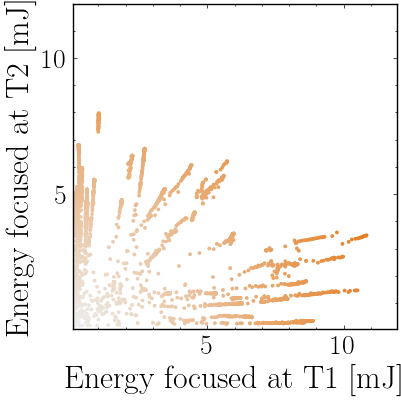

In [38]:
fig, axes = plot_pareto_front(
    pareto_objectives_data,
    figsize=(4, 4),
    xlim=(0, 12),
    ylim=(0, 12),
    fontsize=21+2,
    ticksize=18+2,
    grid=False,
    colors=("#ecf0f1", "#e67e22"),
)
# Make spines thicker
for spine in axes.spines.values():
    spine.set_linewidth(1)
axes.locator_params(axis="both", integer=True)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/pareto_front.png",
    dpi=300,
)

### Best equiperformance design


In [5]:
pareto_data_filename = f"paretoSample_weights_0.500_0.500_iniAngle_35"
# Another good one is "paretoSample_weights_0.600_0.400_iniAngle_35"
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/{optimization.name}/pareto/{pareto_folder}/{pareto_data_filename}.pkl",
    )
)
print(
    f"Objective ratios: {jnp.array(optimization.objective_values_individual).T[0]/jnp.array(optimization.objective_values_individual).T[1]}")

Objective ratios: [0.94324405 0.94334922 0.94342254 0.94344784 0.94342556 0.94244477
 0.91803722 0.90931794 0.9278482  0.92669132 0.90979757 1.0369044
 0.97126281 0.94495658 0.91569213 0.90129353 0.90053398 0.89461102
 0.89322217 0.89273803 0.89318384 0.8931838  0.8931838  0.91928085
 0.91525651 1.07028803 0.98570324 0.93099457 0.92877794 0.92236265
 0.92325125 0.92835313 0.92549954 0.92240699]


#### Plot design

(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

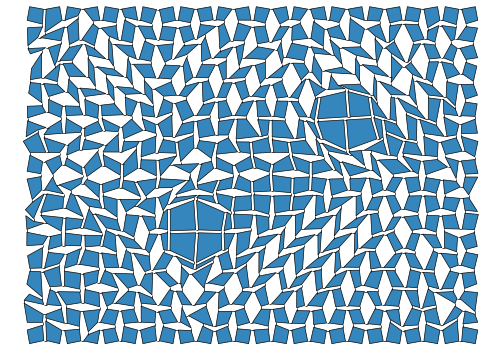

In [9]:
plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    figsize=(5, 3.5),
    axis=False
)


#### Plot average kinetic energy distribution


##### Compressive strain: 2%

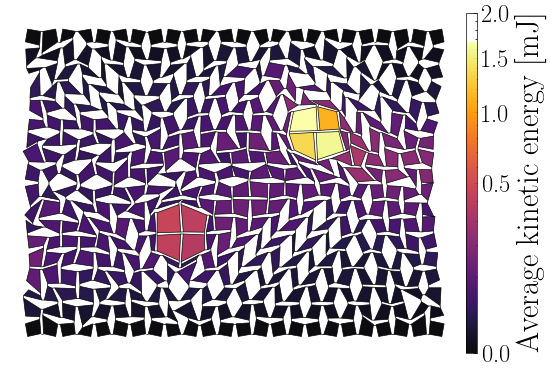

In [62]:
solution_data = optimization.forward_problem.solution_data[0]
design_label = f"average_kinetic_energy_compression_{optimization.forward_input.compressive_strain[0]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
)

##### Compressive strain: 5%

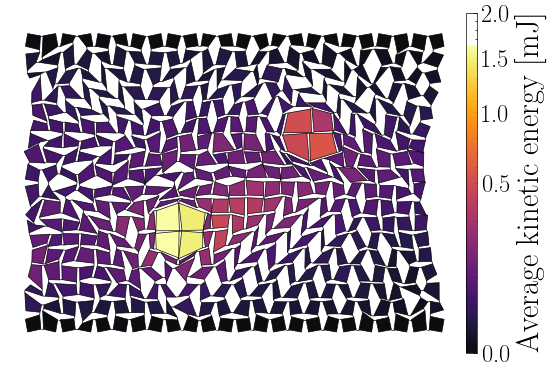

In [63]:
solution_data = optimization.forward_problem.solution_data[1]
design_label = f"average_kinetic_energy_compression_{optimization.forward_input.compressive_strain[1]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=average_kinetic_energy_per_block(
        solution_data,
        compute_inertia(
            vertices=solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=0.5,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
)

#### Response animations

In [ ]:
generate_response_animations(
    optimization=optimization,
    field="v",  # Velocity field
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    filename_prefix="response_animation_no_grid",
    figsize=(5.5, 3.7),
    fontsize=18,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    axis=False,
    iteration=-1,
)

#### Plot energy maps time-evolution vs compressive strain

##### Kinetic energy maps

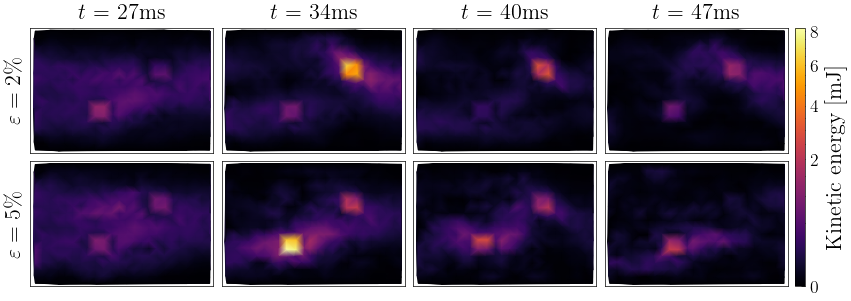

In [70]:
fig, axes = plot_kinetic_energy_evolution_vs_compression(
    optimization,
    solution_data_list=[optimization.forward_problem.solution_data[0],
                        optimization.forward_problem.solution_data[1]],
    timepoints=[80, 100, 120, 140],
    row_labels=[fr"$\varepsilon={optimization.forward_input.compressive_strain[0]*100:.0f}\%$",
                fr"$\varepsilon={optimization.forward_input.compressive_strain[1]*100:.0f}\%$"],
    grid=False,
    figsize=(8.5, 3.),
    cmap="inferno",
    fontsize=16,
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/kinetic_energy_evolution_vs_compression.png",
    dpi=300
)

In [6]:
# Add more compression levels
if not optimization.forward_problem.is_setup:
    optimization.forward_problem.setup()

compressive_strains_sweep = (0.0001, 0.01, 0.02, 0.04, 0.05, 0.06, 0.07, 0.08)
compressive_strain_rates = (0.25,)*len(compressive_strains_sweep)
amplitudes = (
    optimization.forward_input.amplitude[0],)*len(compressive_strains_sweep)
loading_rates = (
    optimization.forward_input.loading_rate[0],)*len(compressive_strains_sweep)
forward_input_array = jnp.array([
    amplitudes,
    loading_rates,
    compressive_strains_sweep,
    compressive_strain_rates,
])

# Pmap the forward problem
solution_data_array = pmap(lambda amplitude, loading_rate, compressive_strain, compressive_strain_rate: optimization.forward_problem.solve(
    optimization.design_values[-1],
    amplitude,
    loading_rate,
    compressive_strain,
    compressive_strain_rate,
    full_simulation_time=False,
    n_timepoints=200,
))(
    *forward_input_array
)
solution_data_list = [SolutionData(
    block_centroids=block_centroids,
    centroid_node_vectors=centroid_node_vectors,
    bond_connectivity=bond_connectivity,
    fields=fields,
    timepoints=timepoints,
) for block_centroids, centroid_node_vectors, bond_connectivity, fields, timepoints in zip(
    solution_data_array.block_centroids,
    solution_data_array.centroid_node_vectors,
    solution_data_array.bond_connectivity,
    solution_data_array.fields,
    solution_data_array.timepoints,
)]

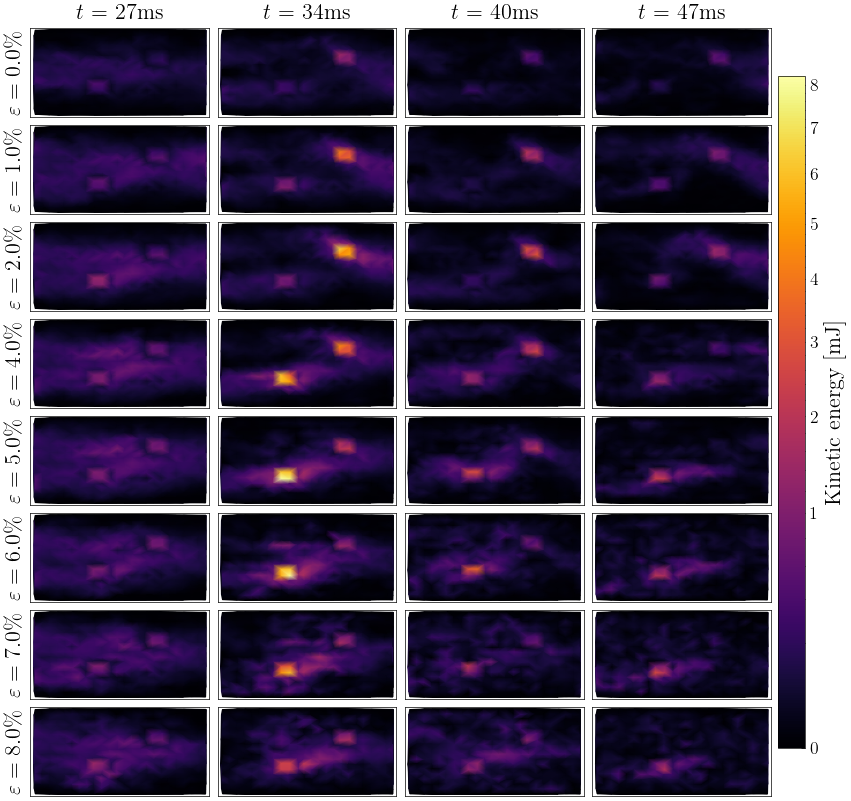

In [11]:
fig, axes = plot_kinetic_energy_evolution_vs_compression(
    optimization,
    solution_data_list=solution_data_list,
    timepoints=[80, 100, 120, 140],
    row_labels=[fr"$\varepsilon={compressive_strain*100:.1f}\%$" for compressive_strain in compressive_strains_sweep],
    grid=False,
    figsize=(8.5, 8.),
    cmap="inferno",
    fontsize=16,
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/kinetic_energy_evolution_vs_compression_more.png",
    dpi=300
)

##### Kinetic and strain energy maps

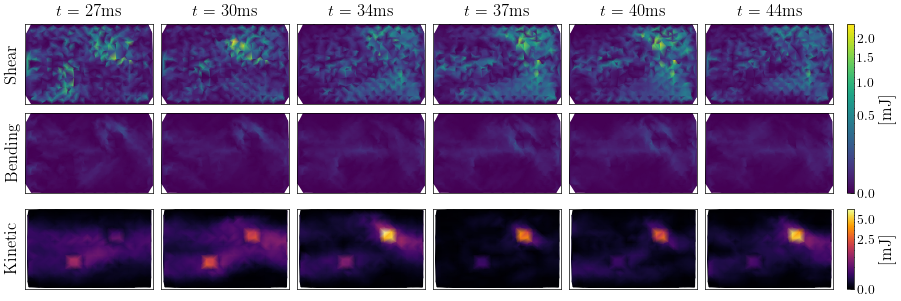

In [50]:
solution_data = optimization.forward_problem.solution_data[0]
plot_label = f"strains_and_kinetic_energy_evolution_compression_{optimization.forward_input.compressive_strain[0]:.2f}"
fig, axes = plot_strains_and_kinetic_energy_evolution_T(
    optimization,
    solution_data=solution_data,
    timepoints=[80, 90, 100, 110, 120, 130],
    grid=False,
    figsize=(9, 3.),
    cmap_strains="viridis",
    show_ticks=False,
    fontsize=12,
    time_label_pos="left",
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/{plot_label}.png",
    dpi=300,
)

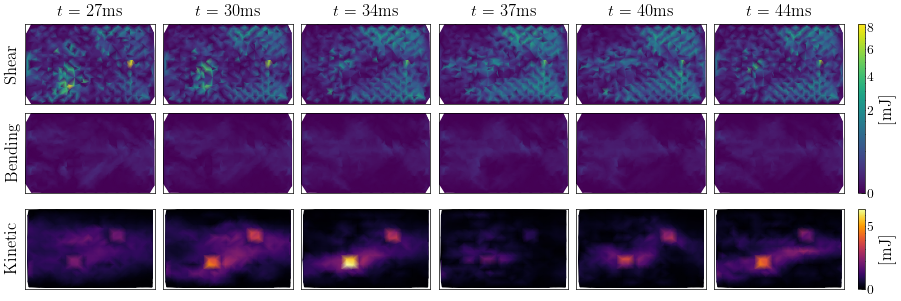

In [49]:
solution_data = optimization.forward_problem.solution_data[1]
plot_label = f"strains_and_kinetic_energy_evolution_compression_{optimization.forward_input.compressive_strain[1]:.2f}"
fig, axes = plot_strains_and_kinetic_energy_evolution_T(
    optimization,
    solution_data=solution_data,
    timepoints=[80, 90, 100, 110, 120, 130],
    grid=False,
    figsize=(9, 3.),
    cmap_strains="viridis",
    show_ticks=False,
    fontsize=12,
    time_label_pos="left",
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/{plot_label}.png",
    dpi=300,
)

##### Contact and kinetic energy maps vs strain

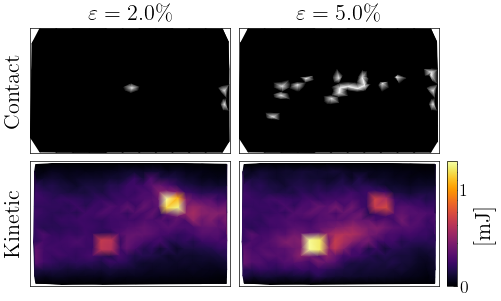

In [78]:
fig, axes = plot_contact_and_kinetic_energy_vs_compression(
    optimization,
    solution_data_list=optimization.forward_problem.solution_data,
    column_labels=[
        fr"$\varepsilon={compressive_strain*100:.1f}\%$" for compressive_strain in optimization.forward_input.compressive_strain],
    grid=False,
    figsize=(5, 3),
    cmap_kinetic="inferno",
    cmap_contact="binary_r",
    fontsize=16,
    show_ticks=False,
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/contact_and_kinetic_energy_vs_compression.png",
    dpi=300
)

##### Energy at targets and contact energy vs strain

In [11]:
# Add more compression levels
if not optimization.is_setup:
    optimization.setup_objective()

compressive_strains_sweep = [0.0001] + [0.005, 0.01, 0.015, 0.02,
                                        0.025, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09]
# compressive_strains_sweep = [0.0001] + jnp.arange(0.005, 0.105, 0.005).tolist()
compressive_strain_rates = (0.25,)*len(compressive_strains_sweep)
amplitudes = (
    optimization.forward_input.amplitude[0],)*len(compressive_strains_sweep)
loading_rates = (
    optimization.forward_input.loading_rate[0],)*len(compressive_strains_sweep)
forward_input_array = jnp.array([
    amplitudes,
    loading_rates,
    compressive_strains_sweep,
    compressive_strain_rates,
])

# Pmap the forward problem
solution_data_array = pmap(lambda amplitude, loading_rate, compressive_strain, compressive_strain_rate: optimization.forward_problem.solve(
    optimization.design_values[-1],
    amplitude,
    loading_rate,
    compressive_strain,
    compressive_strain_rate,
    full_simulation_time=False,
    n_timepoints=200,
))(
    *forward_input_array
)
solution_data_sims = [SolutionData(
    block_centroids=block_centroids,
    centroid_node_vectors=centroid_node_vectors,
    bond_connectivity=bond_connectivity,
    fields=fields,
    timepoints=timepoints,
) for block_centroids, centroid_node_vectors, bond_connectivity, fields, timepoints in zip(
    solution_data_array.block_centroids,
    solution_data_array.centroid_node_vectors,
    solution_data_array.bond_connectivity,
    solution_data_array.fields,
    solution_data_array.timepoints,
)]

contact_energy = build_contact_energy(
    bond_connectivity=optimization.forward_problem.solution_data[0].bond_connectivity)
contact_energies = jnp.array([
    contact_energy(
        block_displacement=solution_data.fields[0, 0],
        control_params=ControlParams(
            geometrical_params=GeometricalParams(
                block_centroids=solution_data.block_centroids,
                centroid_node_vectors=solution_data.centroid_node_vectors,
            ),
            mechanical_params=MechanicalParams(
                bond_params=None,
                density=0.,
                contact_params=ContactParams(
                    k_contact=optimization.forward_problem.k_contact,
                    min_angle=optimization.forward_problem.min_angle,
                    cutoff_angle=optimization.forward_problem.cutoff_angle,
                ),
            ),
        ),
    ) for solution_data in solution_data_sims])
kinetic_energies = jnp.array([
    [
        kinetic_energy(
            block_velocity=solution_data.fields[:, 1, target_blocks, :],
            inertia=compute_inertia(
                vertices=solution_data.centroid_node_vectors,
                density=problem.density
            )[target_blocks]
        ) for solution_data in solution_data_sims
    ] for target_blocks in optimization.target_blocks
])

# Save the simulation data sweep
save_data(
    f"../data/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/compression_sweep_simulation_data_nominal_input.pkl",
    pd.DataFrame(
        {
            "compression": compressive_strains_sweep,
            "simulation_data": solution_data_sims,
            "kinetic_energy_target_1": kinetic_energies[0],
            "kinetic_energy_target_2": kinetic_energies[1],
            "contact_energy": contact_energies,
        }
    ),
)

Data saved at ../data/quads_focusing_switching_static_tuning_3dp_pla_shims/pareto/opt_with_angle_30_and_length_3_constraints_quads_24x18_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_target_sizes_((2, 2), (2, 2))_target_shifts_((5, 3), (-3, -3))_compressive_strains_(0.02, 0.05)/best_design_50_50_paretoSample_weights_0.500_0.500_iniAngle_35/compression_sweep_simulation_data_nominal_input.pkl


In [95]:
compression_sweep_data = load_data(
    f"../data/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/compression_sweep_simulation_data_nominal_input.pkl",
)
compression_sweep_data

compression                                    simulation_data  \
0        0.0001  ([[0.5300967269752231, 0.7164706780490562], [1...   
1        0.0050  ([[0.5300967269752231, 0.7164706780490562], [1...   
2        0.0100  ([[0.5300967269752231, 0.7164706780490562], [1...   
3        0.0150  ([[0.5300967269752231, 0.7164706780490562], [1...   
4        0.0200  ([[0.5300967269752231, 0.7164706780490562], [1...   
5        0.0250  ([[0.5300967269752231, 0.7164706780490562], [1...   
6        0.0300  ([[0.5300967269752231, 0.7164706780490562], [1...   
7        0.0400  ([[0.5300967269752231, 0.7164706780490562], [1...   
8        0.0450  ([[0.5300967269752231, 0.7164706780490562], [1...   
9        0.0500  ([[0.5300967269752231, 0.7164706780490562], [1...   
10       0.0550  ([[0.5300967269752231, 0.7164706780490562], [1...   
11       0.0600  ([[0.5300967269752231, 0.7164706780490562], [1...   
12       0.0700  ([[0.5300967269752231, 0.7164706780490562], [1...   
13       0.0800  ([[0.5300967269752231, 0.7164706780490562], [1...   
14       0.0900  ([[0.5300967269752231, 0.7164706780490562], [1...   

    kinetic_energy_target_1  kinetic_energy_target_2  contact_energy  
0                243.628427               101.626930        0.000000  
1                424.807185               154.658339        0.001578  
2                683.726448               212.036951        0.014362  
3                957.312465               274.036869        0.022776  
4               1145.598464               330.315629        0.035239  
5                950.967411               441.733007        0.059341  
6                886.971692               552.769494        0.097151  
7                613.617899               894.159774        0.178764  
8                482.812168              1086.078009        0.247808  
9                371.496873              1241.966346        0.303632  
10               297.669385              1233.462760        0.354956  
11               253.905141              1090.309142        0.413276  
12               235.006735               819.343804        0.613873  
13               244.119693               664.411998        0.872423  
14               261.486044               541.154594        1.133666

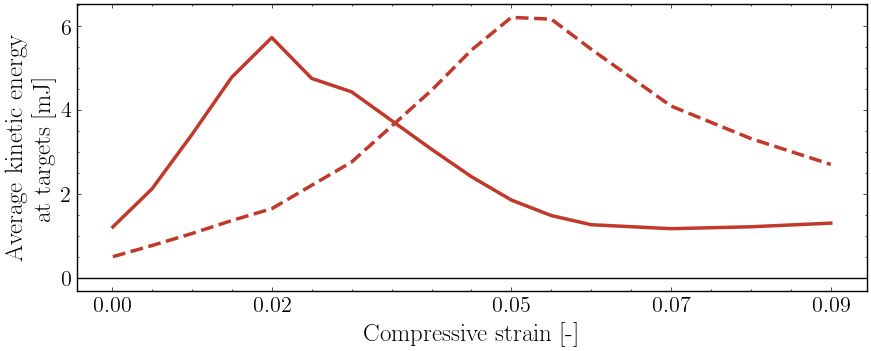

In [115]:
compressive_strains_sweep = compression_sweep_data.compression
kinetic_energies_1 = compression_sweep_data.kinetic_energy_target_1
kinetic_energies_2 = compression_sweep_data.kinetic_energy_target_2
contact_energies = compression_sweep_data.contact_energy

# Plot a double y-axis plot
fig, axes = plt.subplots(figsize=(8.7, 3.5), constrained_layout=True)
# Target 1
axes.plot(compressive_strains_sweep, kinetic_energies_1/optimization.forward_problem.n_timepoints,
          label="Normalized kinetic energy at target 1", color="#c0392b", lw=2.5)
# Target 2
axes.plot(compressive_strains_sweep, kinetic_energies_2/optimization.forward_problem.n_timepoints,
          label="Normalized kinetic energy at target 2", color="#c0392b", lw=2.5, ls="--")
# # Contact
# axes2 = axes.twinx()
# axes2.plot(compressive_strains_sweep, contact_energies/contact_energies.max(),
#            label="Contact", color="#2c3e50", lw=2.5)
axes.set_xlabel("Compressive strain [-]", fontsize=18)
axes.set_ylabel("Average kinetic energy\n at targets [mJ]", fontsize=18)
# axes2.set_ylabel("Normalized contact energy [-]", fontsize=16, color="#2c3e50")
axes.tick_params(labelsize=16)
# axes2.tick_params(labelsize=14)
# axes.set_ylim(-0.04, 1.04)
# axes2.set_ylim(-0.04, 1.04)
axes.grid(False)
# axes2.grid(False)
axes.axhline(y=0, color="black", lw=1)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
# Color the spines
# axes.spines.left.set_color("#c0392b")
# axes.spines.right.set_color("#2c3e50")
# axes2.spines.left.set_color("#c0392b")
# axes2.spines.right.set_color("#2c3e50")
# Color ticks and tick labels
# axes.tick_params(axis="y", colors="#c0392b")
# axes2.tick_params(axis="y", colors="#2c3e50")
# Make sure x ticks include all compressions
axes.set_xticks([0, 0.02, 0.05, 0.07, 0.09])
# fig.legend(loc="lower right", fontsize=14, fancybox=True,
#            bbox_to_anchor=(1., 0.0), framealpha=0.9)
fig.savefig(f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/target_kinetic_and_contact_energy_vs_compression.png",
            bbox_inches="tight", dpi=300)
fig.savefig(f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/target_kinetic_energy_vs_compression.png",
            bbox_inches="tight", dpi=300)

#### Plot contact maps on design

In [65]:
# Compute contact energy
contact_energies = jnp.array([
    compute_contact_energies(
        block_displacement=solution_data.fields[0, 0],
        control_params=ControlParams(
            geometrical_params=GeometricalParams(
                block_centroids=solution_data.block_centroids,
                centroid_node_vectors=solution_data.centroid_node_vectors,
            ),
            mechanical_params=MechanicalParams(
                bond_params=None,
                density=0.,
                contact_params=ContactParams(
                    k_contact=optimization.forward_problem.k_contact,
                    min_angle=optimization.forward_problem.min_angle,
                    cutoff_angle=optimization.forward_problem.cutoff_angle,
                ),
            ),
        ),
        bond_connectivity=solution_data.bond_connectivity,
    )
    for solution_data in optimization.forward_problem.solution_data
])
# Binary contact energies to show contact or no contact
contact_energies = jnp.where(contact_energies > 0., 1., 0.)
# Binary array with blocks in contact or not
contact_state_blocks = jnp.zeros(
    (2, optimization.forward_problem.solution_data[0].block_centroids.shape[0]), dtype=contact_energies.dtype)
contact_state_blocks = contact_state_blocks.at[:,
                                               optimization.forward_problem.solution_data[0].bond_connectivity[:, 0]//4].add(contact_energies)
contact_state_blocks = contact_state_blocks.at[:,
                                               optimization.forward_problem.solution_data[0].bond_connectivity[:, 1]//4].add(contact_energies)

##### Compressive strain: 2%

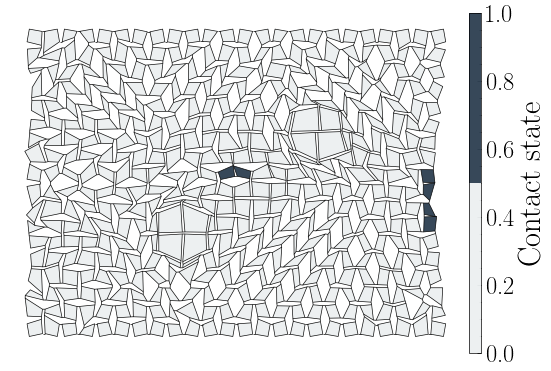

In [91]:
solution_data = optimization.forward_problem.solution_data[0]
design_label = f"contacts_compression_{optimization.forward_input.compressive_strain[0]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=contact_state_blocks[0],
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=1.,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap",
        ("#ecf0f1", "#2c3e50"),
        N=2
    ),
    cmap_label="Contact state",
    fontsize=22,
    grid=False,
    axis=False,
)

##### Compressive strain: 5%

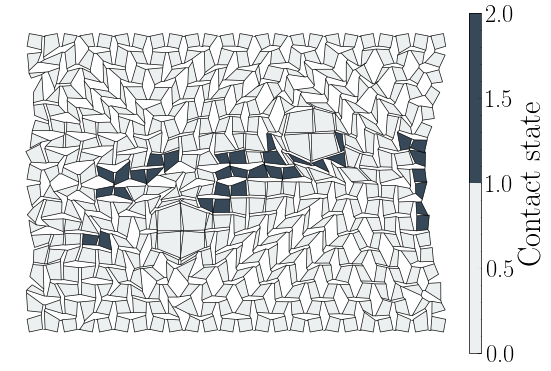

In [94]:
solution_data = optimization.forward_problem.solution_data[1]
design_label = f"contacts_compression_{optimization.forward_input.compressive_strain[1]:.2f}"
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    design_label=design_label,
    figsize=(5.5, 3.7),
    field_values=contact_state_blocks[1],
    deformed=True,
    block_displacements=solution_data.fields[0, 0],
    scaling=1.,
    cmap=matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap",
        ("#ecf0f1", "#2c3e50"),
        N=2
    ),
    cmap_label="Contact state",
    fontsize=22,
    grid=False,
    axis=False,
)